In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import wandb
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


# **Setup**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 73.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 41.2 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installat

Saving kaggle.json to kaggle.json
/bin/bash: line 1: /content/drive/MyDrive/ColabNotebooks/kaggle_API_credentials/kaggle.json: No such file or directory
 93% 264M/285M [00:02<00:00, 64.3MB/s]
100% 285M/285M [00:02<00:00, 107MB/s] 


<IPython.core.display.Javascript object>

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: tekla-tsutskha (tekla-tsutskha-free-university-of-tbilisi-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


challenges-in-representation-learning-facial-expression-recognition-challenge.zip
drive
example_submission.csv
fer2013.tar.gz
icml_face_data.csv
sample_data
test.csv
train.csv
wandb
Dataset Shape:
Training set: (28709, 2)
Test set: (7178, 1)
Columns: ['emotion', 'pixels']
Emotion distribution:
emotion
3    7215
6    4965
4    4830
2    4097
0    3995
5    3171
1     436
Name: count, dtype: int64
Dataset shape: (7178, 1)
Columns: ['pixels']


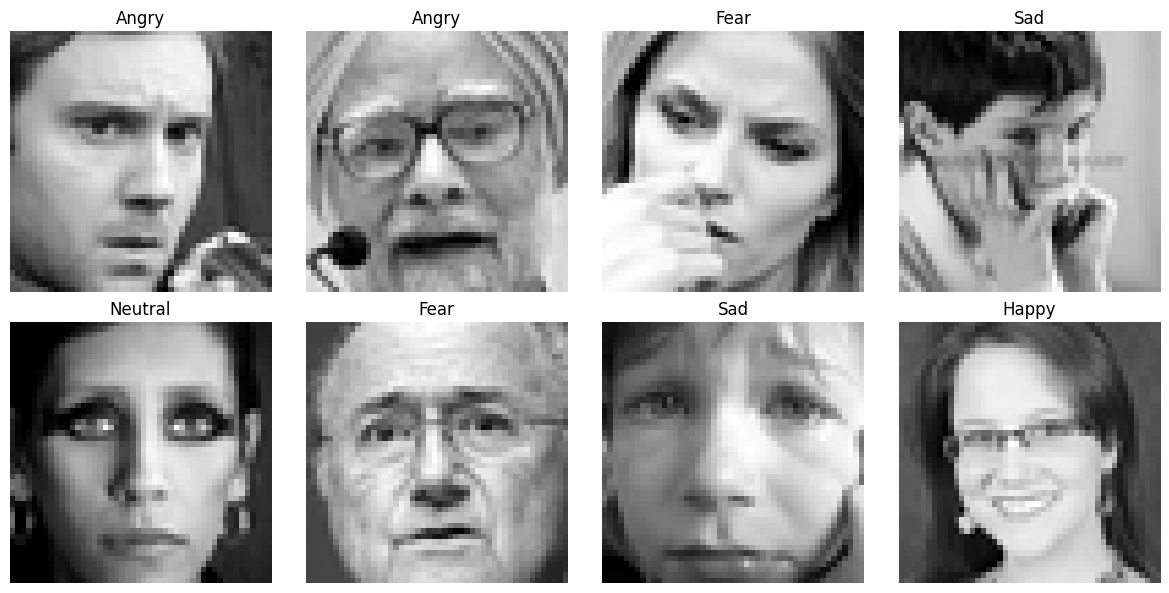

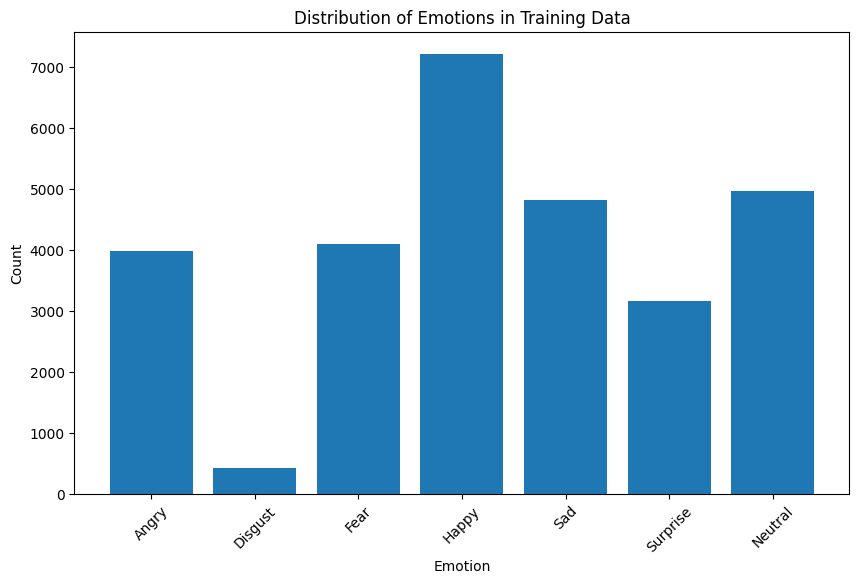

Data exploration complete!
Key observations:
- 48x48 grayscale images
- 7 emotion classes
- Check for class imbalance
- Images are relatively low resolution
Setup complete! Ready for experiments.


In [3]:
%run  "/content/drive/MyDrive/Colab Notebooks/01_data_exploration_and_setup.ipynb"


# **Simple CNN Model**

In [4]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=7):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 12 * 12, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 12 * 12)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

# **Training**

In [10]:
def train_model(model, train_loader, val_loader, num_epochs=30, lr=0.001):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Initialize wandb
    wandb.init(
        project="facial-expression-recognition",
        name="experiment_1_baseline_simple_cnn",
        config={
            "model": "SimpleCNN",
            "epochs": num_epochs,
            "learning_rate": lr,
            "batch_size": train_loader.batch_size,
            "optimizer": "Adam"
        }
    )

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            pred = output.argmax(dim=1)
            correct += pred.eq(target).sum().item()
            total += target.size(0)

        train_loss /= len(train_loader)
        train_acc = 100. * correct / total

        # Validation
        model.eval()
        val_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = criterion(output, target)

                val_loss += loss.item()
                pred = output.argmax(dim=1)
                correct += pred.eq(target).sum().item()
                total += target.size(0)

        val_loss /= len(val_loader)
        val_acc = 100. * correct / total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Log to wandb
        wandb.log({
            "epoch": epoch,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_accuracy": train_acc,
            "val_accuracy": val_acc
        })

        if epoch % 5 == 0:
            print(f'Epoch {epoch}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

    wandb.finish()
    return train_losses, val_losses, train_accs, val_accs


# **Run the experiment**

In [7]:
model = SimpleCNN()
train_loader, val_loader = create_basic_loaders(batch_size=64)

print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
print("Starting training...")

train_losses, val_losses, train_accs, val_accs = train_model(model, train_loader, val_loader)

Model parameters: 1,199,495
Starting training...


num_classes,▁
total_samples,▁
num_classes,7
total_samples,28709


Epoch 0: Train Loss: 1.6430, Train Acc: 35.17%, Val Loss: 1.5113, Val Acc: 39.76%
Epoch 5: Train Loss: 1.1329, Train Acc: 56.90%, Val Loss: 1.2438, Val Acc: 53.20%
Epoch 10: Train Loss: 0.7987, Train Acc: 70.53%, Val Loss: 1.3077, Val Acc: 53.97%
Epoch 15: Train Loss: 0.5822, Train Acc: 78.18%, Val Loss: 1.4577, Val Acc: 54.25%
Epoch 20: Train Loss: 0.4649, Train Acc: 82.98%, Val Loss: 1.6377, Val Acc: 53.20%
Epoch 25: Train Loss: 0.3972, Train Acc: 85.35%, Val Loss: 1.7566, Val Acc: 54.65%


epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▂▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇▇▇█████████
train_loss,█▇▆▆▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▄▅▆▇▇█▇████████████▇██████▇▇▇
val_loss,▄▂▂▂▁▁▁▁▁▂▂▂▂▃▃▃▄▄▄▅▅▆▆▆▇▇▇▇▇█
epoch,29
train_accuracy,87.13371
train_loss,0.34977
val_accuracy,53.39603
val_loss,1.89761


# **Result Analyze**

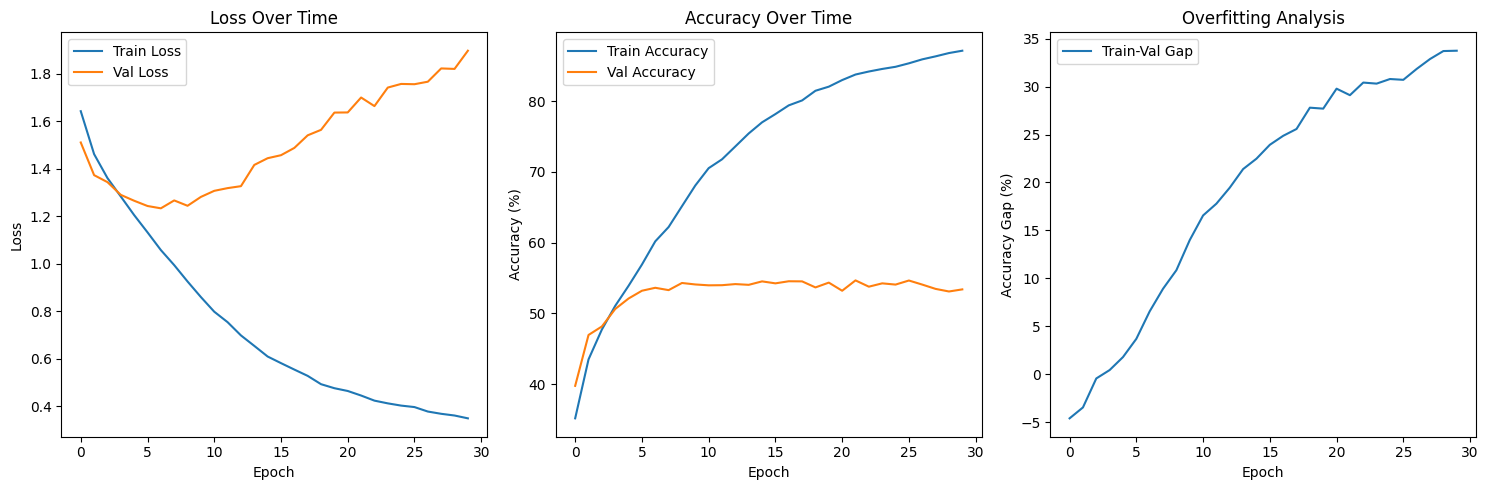

In [8]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Over Time')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy')
plt.plot(val_accs, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy Over Time')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(np.array(train_accs) - np.array(val_accs), label='Train-Val Gap')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Gap (%)')
plt.title('Overfitting Analysis')
plt.legend()

plt.tight_layout()
plt.show()

# **Experiment Analisation**

In [9]:
print("=== EXPERIMENT 1: BASELINE SIMPLE CNN ANALYSIS ===")
print(f"Final Training Accuracy: {train_accs[-1]:.2f}%")
print(f"Final Validation Accuracy: {val_accs[-1]:.2f}%")
print(f"Train-Val Gap: {train_accs[-1] - val_accs[-1]:.2f}%")
print()
print("EXPECTED OUTCOME: UNDERFITTING")
print("Analysis:")
if val_accs[-1] < 50:
    print("✓ Low validation accuracy confirms underfitting")
    print("✓ Model is too simple for the complexity of facial expressions")
    print("✓ Small train-val gap indicates insufficient model capacity")
else:
    print("⚠ Higher than expected accuracy - model may be more capable")

print()
print("INSIGHTS:")
print("- Simple 2-layer CNN lacks capacity for complex facial features")
print("- Need to add more layers or increase channel dimensions")
print("- Low accuracy suggests need for architectural improvements")
print()
print("NEXT STEPS:")
print("- Experiment 2: Add more convolutional layers")
print("- Experiment 3: Add batch normalization")
print("- Experiment 4: Increase model capacity")

# Save model
torch.save(model.state_dict(), 'simple_cnn_baseline.pth')

=== EXPERIMENT 1: BASELINE SIMPLE CNN ANALYSIS ===
Final Training Accuracy: 87.13%
Final Validation Accuracy: 53.40%
Train-Val Gap: 33.74%

EXPECTED OUTCOME: UNDERFITTING
Analysis:
⚠ Higher than expected accuracy - model may be more capable

INSIGHTS:
- Simple 2-layer CNN lacks capacity for complex facial features
- Need to add more layers or increase channel dimensions
- Low accuracy suggests need for architectural improvements

NEXT STEPS:
- Experiment 2: Add more convolutional layers
- Experiment 3: Add batch normalization
- Experiment 4: Increase model capacity
